We plot the histograms of the eigenvalues

In [1]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.optimize import curve_fit, OptimizeWarning
import importlib.util
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils
from scipy.stats import linregress
import warnings



plt.rcParams.update({
    "text.usetex": False, # Disable LaTeX rendering
    "font.family": "serif", # Use a serif font
    # You might still request Computer Modern, Matplotlib will try to find it
    # if installed as a system font, otherwise fallback to another serif.
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm" # Use Computer Modern-like math fonts with mathtext
})

In [3]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)
input_drive = "0.01"
# delta_scale = "linear"
delta_scale = "log-scale"


folder_paths = {
    100: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N100_z_{input_drive}/{input_type}/',
    125: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N125_z_{input_drive}/{input_type}/',
    167: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N167_z_{input_drive}/{input_type}/',
    250: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N250_z_{input_drive}/{input_type}/',
    500: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N500_z_{input_drive}/{input_type}/',
    1000: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N1000_z_{input_drive}/{input_type}/'
}

In [4]:
# %% Define a function to load data from a folder
def load_data(folder_path):
    # This dictionary will map each tensor name (file name without .pt)
    # to a dictionary that maps deltaval values to the loaded tensor.
    all_data = {}
    # The regular expression below finds folders that contain the right mu and delta_scale,
    # and extracts the delta value.
    # pattern = re.compile(
    #     r'^(?=.*_mu_{})'
    #     r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(delta_scale))
    # )
    delta_vals = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]


    delta_pattern = "|".join(re.escape(str(delta)) for delta in delta_vals)

    # pattern = re.compile(
    #     r'^(?=.*_mu_{})'
    #     r'.*_delta_({})_{}$'.format(re.escape(mu), delta_pattern, re.escape(delta_scale))
    # )

    pattern = re.compile(
        r'^(?=.*_mu_{})'         # ensure somewhere in the string you have “_mu_<mu>”
        .format(re.escape(mu)) +
        r'.*_delta_({})(?:_.*)?$'  # capture only delta; allow _anything afterwards (or nothing)
        .format(delta_pattern)
    )

    representative_subfolder = None

    # Loop over all items in the main folder
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            match = pattern.search(subfolder)
            if match:
                representative_subfolder = subfolder
                # Convert the captured delta string to a float
                deltaval = float(match.group(1))
                
                # Loop over each file in the subfolder
                for filename in os.listdir(subfolder_path):
                    if filename.endswith('.pt'):
                        tensor_name = os.path.splitext(filename)[0]
                        tensor = torch.load(os.path.join(subfolder_path, filename))
                        if tensor_name not in all_data:
                            all_data[tensor_name] = {}
                        all_data[tensor_name][deltaval] = tensor

    # Load parameters from a representative subfolder
    param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
    with open(param_file_path, 'r') as f:
        params = json.load(f)
    
    # For example, we are interested in the eigenvalue data.
    eigvals_dict = all_data['eigvals_J']
    return eigvals_dict, params

# %% Load data for each N into a new dictionary.
data_by_N = {}
for N_val, folder_path in folder_paths.items():
    eigvals_dict, params = load_data(folder_path)
    data_by_N[N_val] = {
         'eigvals_dict': eigvals_dict,
         'params': params
    }

# %% Build a set of all delta values available across different N folders.
all_delta_vals = set()
for data in data_by_N.values():
    all_delta_vals.update(data['eigvals_dict'].keys())
all_delta_vals = sorted(all_delta_vals)


In [ ]:
# Create a color mapping so that the same delta always gets the same color.
colors = plt.get_cmap("tab10")

# delta_vals = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
delta_vals = [0.6, 0.5]

# %% Plot the eigenvalue histograms for each N on the same axes.
plt.figure(figsize=(10, 6))
global_min = float('inf')
global_max = float('-inf')

# Loop over each N and then each delta value in that dataset.
for N_val, data in data_by_N.items():
    eigvals_dict = data['eigvals_dict']
    for i, delta_val in enumerate(delta_vals):
        eigvals = eigvals_dict[delta_val]
        # Compute the max real parts scaled by 0.002
        max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
        
        # Choose a specific z index (here z_idx = 0) and the first trial
        z_idx = 0
        max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
        # Keep only non-positive values
        max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
        # Convert tensor to numpy array
        data_arr = max_real_each_trial_input.cpu().numpy()
        
        # Update global x-axis limits for consistent ticks later.
        global_min = min(global_min, data_arr.min())
        global_max = max(global_max, data_arr.max())
        
        # Plot a line histogram using a consistent color for the given delta.
        plt.hist(data_arr, bins=40, density=True, histtype='step', linewidth=2.5,
                 color=colors(i), label=f"N = {N_val}, Δ = {delta_val}")

# Set labels, title, and ticks
plt.xlabel(r"$\lambda$", fontsize=22)
plt.ylabel('Density', fontsize=22)
# plt.title("Histogram of Eigenvalues for Different N", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax = plt.gca()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
# ax.xaxis.set_major_formatter(formatter)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both', nbins=5))

# Build a custom legend that groups by delta (so the color coding is clear)
legend_elements = []
for i, delta_val in enumerate(delta_vals):
    legend_elements.append(Line2D([0], [0], color=colors(i), lw=2.5, label=f"Δ = {delta_val}"))
plt.legend(handles=legend_elements, fontsize=12)
plt.xlim(left=None, right=1e-8)
# plt.yscale('log')
# plt.ylim(1, 1e3)

plt.tight_layout()
plt.show()


In [ ]:
delta_vals = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

colors = plt.get_cmap("tab10")

fig, axes = plt.subplots(4, 3, figsize=(18, 18))
axes = axes.flatten()

global_min = float('inf')
global_max = float('-inf')

# Precompute all data_arrs for consistent axis limits
all_data_arrs = []

for delta_val in delta_vals:
    data_per_delta = []
    for j, (N_val, data) in enumerate(data_by_N.items()):
        eigvals_dict = data['eigvals_dict']
        eigvals = eigvals_dict[delta_val]

        max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
        z_idx = 0
        max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
        max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
        data_arr = max_real_each_trial_input.cpu().numpy()

        global_min = min(global_min, data_arr.min())
        global_max = max(global_max, data_arr.max())

        data_per_delta.append((j, N_val, data_arr))
    all_data_arrs.append(data_per_delta)

# Now actually plot using the same global limits
for idx, (delta_val, data_per_delta) in enumerate(zip(delta_vals, all_data_arrs)):
    ax = axes[idx]
    for j, N_val, data_arr in data_per_delta:
        ax.hist(data_arr, bins=40, density=True, histtype='step', linewidth=2.5,
                color=colors(j), label=f"N = {N_val}")

    ax.set_title(rf"$\Delta$ = {delta_val}", fontsize=18)
    ax.set_xlabel(r"$\lambda$", fontsize=20)
    ax.set_ylabel(r"$P(\lambda)$", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16, width=1.5)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both', nbins=5))
    ax.set_xlim(left=global_min, right=0.005)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    ax.legend(fontsize=14)

# Remove any unused subplots (if fewer than 12 deltas were used)
for i in range(len(delta_vals), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

# save the figure
folder_loc = f'../figures/mu_{mu}/fig_histogram_z_{input_drive}/'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'histogram_supplementary'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:

# %% (Optional) Plot the gap distance vs. Δ for each N on the same axes.
plt.figure(figsize=(8,6))
for N_val, data in data_by_N.items():
    eigvals_dict = data['eigvals_dict']
    delta_vals_sorted = sorted(eigvals_dict.keys())
    gapped_distances = []
    for delta_val in delta_vals_sorted:
        eigvals = eigvals_dict[delta_val]
        max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
        z_idx = 0
        max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
        max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
        data_arr = max_real_each_trial_input.cpu().numpy()
        gapped_distances.append(np.abs(data_arr.max()))
    
    # Plot with a distinct line for each N but reusing the same color mapping for each Δ.
    # Here we use markers for the gap distances for each N.
    plt.plot(delta_vals_sorted, gapped_distances, marker='o', markersize=8, linewidth=2,
             label=f"N = {N_val}")

plt.xlabel(r'$\Delta$', fontsize=20)
plt.ylabel('Gap distance', fontsize=20)
plt.title('Spectral Gap vs. $\Delta$', fontsize=22)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit, OptimizeWarning
from scipy.stats import linregress
import os
import warnings
from collections import OrderedDict # For legend handling

# --- Configuration ---
eigenvalue_rank = 2 # Define the rank of the eigenvalue to analyze (1 = largest, 2 = second largest, etc.) defined wrt to the smallest system size.
fit_start_index = 2
min_points_for_fit = 3

# Assume previous setup code has defined: data_by_N, plt settings, mu, input_drive
# Make sure mu and input_drive are defined for saving plots later, e.g.:
# mu = "0.0"
# input_drive = "0.01"

# Helper function for ordinal numbers (1st, 2nd, 3rd, etc.)
def get_ordinal(n):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
        suffix = suffixes.get(n % 10, 'th')
    return str(n) + suffix

ordinal_rank = get_ordinal(eigenvalue_rank) # Get the ordinal string for the rank

# --- Data Loading and Preprocessing ---
delta_vals_to_plot = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

available_deltas_per_N = [set(data['eigvals_dict'].keys()) for N_val, data in data_by_N.items() if N_val in data_by_N and 'eigvals_dict' in data]
if not available_deltas_per_N:
     print("Error: No eigenvalue data loaded for any system size N.")
     available_deltas_common = set()
else:
     valid_N_keys = [N for N in data_by_N if data_by_N[N].get('eigvals_dict')]
     if not valid_N_keys:
         print("Error: No system sizes found with valid eigenvalue data.")
         available_deltas_common = set()
     else:
        available_deltas_per_N = [set(data_by_N[N]['eigvals_dict'].keys()) for N in valid_N_keys]
        available_deltas_common = set.intersection(*available_deltas_per_N)

delta_vals_to_plot = sorted([d for d in delta_vals_to_plot if d in available_deltas_common])

if not delta_vals_to_plot:
    print("Error: None of the specified delta_vals_to_plot are available across all loaded system sizes.")
    exit()
else:
    print(f"Performing scaling analysis for the {ordinal_rank} largest eigenvalue real part for delta values: {delta_vals_to_plot}")

results = {delta: {'N': [], 'mean': [], 'std': []} for delta in delta_vals_to_plot}
system_sizes_N = sorted(data_by_N.keys()) # Ensure N is sorted for indexing

# --- Calculate Normalized Rank based on Smallest System Size ---
N_min = system_sizes_N[0]
total_eigvals_min = 2 * N_min
normalized_rank = (eigenvalue_rank - 1) / (total_eigvals_min - 1)
print(f"Using N_min={N_min} as reference. Tracking eigenvalue with normalized rank: {normalized_rank:.4f} (corresponding to {ordinal_rank} rank in N={N_min}).")
print("-" * 30)

for delta_val in delta_vals_to_plot:
    temp_N = []
    temp_mean = []
    temp_std = []
    print(f"Processing Delta = {delta_val}") # Added print statement
    for N_val in system_sizes_N: # Iterate through sorted N
        if N_val in data_by_N and delta_val in data_by_N[N_val].get('eigvals_dict', {}):
            data = data_by_N[N_val]
            eigvals = data['eigvals_dict'][delta_val]
            total_eigvals_current = 2 * N_val

            # Sort eigenvalues by real part in descending order along the last dimension
            # Ensure we work with the real part
            real_eigvals = eigvals.real
            all_nan_rows_mask = torch.all(torch.isnan(real_eigvals), dim=3)
            real_eigvals = real_eigvals[~all_nan_rows_mask].unsqueeze(0).unsqueeze(0)
            
            
            sorted_real_parts, _ = torch.sort(real_eigvals, dim=3, descending=True)

            # Calculate the target floating-point index for the current N based on normalized rank
            # target_index_float is 0-based.
            target_index_float = normalized_rank * (total_eigvals_current - 1)

            # Determine indices for interpolation
            idx_floor = math.floor(target_index_float)
            idx_ceil = math.ceil(target_index_float)

            # Ensure indices are within the bounds of the sorted eigenvalues
            idx_floor = max(0, min(idx_floor, total_eigvals_current - 1))
            idx_ceil = max(0, min(idx_ceil, total_eigvals_current - 1))

            # Get eigenvalues at floor and ceiling indices across all trials/other dims
            val_floor = sorted_real_parts[:, :, :, idx_floor]
            val_ceil = sorted_real_parts[:, :, :, idx_ceil]

            # Perform linear interpolation
            if idx_floor == idx_ceil:
                interpolated_eigval_real = val_floor # Target index is an integer
            else:
                weight = target_index_float - idx_floor
                interpolated_eigval_real = val_floor * (1.0 - weight) + val_ceil * weight

            # Apply scaling factor
            interpolated_eigval_scaled = interpolated_eigval_real * 0.002

            z_idx = 0 # Kept from original code
            data_for_trials = interpolated_eigval_scaled[0, z_idx, :]

            # Filter non-positive values (ensure it's done AFTER potentially selecting z_idx)
            filtered_data = data_for_trials[data_for_trials <= 0]
            data_arr = filtered_data.cpu().numpy() # Convert to numpy for mean/std

            if data_arr.size > 0:
                mean_val = np.mean(data_arr)
                std_val = np.std(data_arr)
                # Append in sorted N order
                temp_N.append(N_val)
                temp_mean.append(mean_val)
                temp_std.append(std_val)
                # print(f"  N={N_val}: Target index={target_index_float:.2f} -> Mean={mean_val:.4e}, Std={std_val:.4e} (from {data_arr.size} trials)") # Optional debug print
            else:
                    print(f"  Warning: N={N_val}, Delta={delta_val}: No valid data points after filtering. Skipping.")
                    pass # Skip if no data left after filtering


    # Store sorted lists in results if data was added
    if temp_N:
        results[delta_val]['N'] = temp_N
        results[delta_val]['mean'] = temp_mean
        results[delta_val]['std'] = temp_std
    else:
        print(f"Warning: No data collected for Delta={delta_val} across any N.")
        # Ensure the entry exists but is empty if no data was found
        results[delta_val] = {'N': [], 'mean': [], 'std': []}


print("-" * 30)

# --- Fit Functions ---
def model_mean_fit(N, mu_inf, A, alpha):
    N = np.asarray(N, dtype=float)
    N[N <= 0] = 1e-9 # Avoid log(0) or division by zero issues
    return mu_inf + A * (N ** (-alpha))

def model_std_fit(N, sigma_inf, B, beta):
    N = np.asarray(N, dtype=float)
    N[N <= 0] = 1e-9 # Avoid log(0) or division by zero issues
    return sigma_inf + B * (N ** (-beta))

# --- Non-linear Fitting ---
fit_parameters_nonlinear = {}
print(f"\nStarting non-linear fits for the {ordinal_rank} eigenvalue...")
print(f"Fitting will use data points starting from index {fit_start_index} (requires at least {min_points_for_fit} points from this index).")

for delta_val in delta_vals_to_plot:
    if delta_val not in results or len(results[delta_val]['N']) == 0:
        print(f"Skipping Delta={delta_val}: No data available.")
        fit_parameters_nonlinear[delta_val] = None
        continue

    N_vals_all = np.array(results[delta_val]['N'])
    mean_vals_all = np.array(results[delta_val]['mean'])
    std_vals_all = np.array(results[delta_val]['std'])

    if len(N_vals_all) <= fit_start_index:
        print(f"Skipping Delta={delta_val}: Not enough data points (need > {fit_start_index}) for fit.")
        fit_parameters_nonlinear[delta_val] = None
        continue

    N_vals_fit = N_vals_all[fit_start_index:]
    mean_vals_fit = mean_vals_all[fit_start_index:]
    std_vals_fit = std_vals_all[fit_start_index:]

    if len(N_vals_fit) < min_points_for_fit:
        print(f"Skipping Delta={delta_val}: Not enough data points ({len(N_vals_fit)}) from index {fit_start_index} for fit (min {min_points_for_fit} required).")
        fit_parameters_nonlinear[delta_val] = None
        continue

    current_delta_params = {'mu_inf': None, 'A': None, 'alpha': None,
                            'sigma_inf': None, 'B': None, 'beta': None,
                            'fit_successful_mean': False, 'fit_successful_std': False}

    # Fit Mean
    try:
        # Initial guesses
        guess_mu_inf = mean_vals_fit[-1] if len(mean_vals_fit) > 0 else 0
        guess_A = (mean_vals_fit[0] - guess_mu_inf) * (N_vals_fit[0] ** 1.0) if len(mean_vals_fit) > 0 else 1.0
        p0_mean = [guess_mu_inf, guess_A, 1.0] # mu_inf, A, alpha
        # Bounds: mu_inf <= 0, A can be positive/negative, alpha > 0
        bounds_mean = ([-np.inf, -np.inf, 1e-6], [0.0, np.inf, np.inf])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            warnings.simplefilter("ignore", category=OptimizeWarning)
            popt_mean, _ = curve_fit(model_mean_fit, N_vals_fit, mean_vals_fit, p0=p0_mean, bounds=bounds_mean, maxfev=5000)

        current_delta_params['mu_inf'] = popt_mean[0]
        current_delta_params['A'] = popt_mean[1]
        current_delta_params['alpha'] = popt_mean[2]
        current_delta_params['fit_successful_mean'] = True
        print(f"Delta={delta_val}: Mean fit successful.")
    except (RuntimeError, ValueError) as e:
         print(f"Delta={delta_val}: Mean fit failed. Error: {e}")
         pass

    # Fit Standard Deviation
    try:
        # Initial guesses
        guess_sigma_inf = std_vals_fit[-1] if len(std_vals_fit) > 0 else 0
        guess_B = (std_vals_fit[0] - guess_sigma_inf) * (N_vals_fit[0] ** 1.0) if len(std_vals_fit) > 0 else 1.0
        p0_std = [guess_sigma_inf, guess_B, 1.0] # sigma_inf, B, beta
        # Bounds: sigma_inf >= 0, B >= 0 (usually std decreases), beta > 0
        bounds_std = ([0.0, 0.0, 1e-6], [np.inf, np.inf, np.inf])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            warnings.simplefilter("ignore", category=OptimizeWarning)
            popt_std, _ = curve_fit(model_std_fit, N_vals_fit, std_vals_fit, p0=p0_std, bounds=bounds_std, maxfev=5000)

        current_delta_params['sigma_inf'] = popt_std[0]
        current_delta_params['B'] = popt_std[1]
        current_delta_params['beta'] = popt_std[2]
        current_delta_params['fit_successful_std'] = True
        print(f"Delta={delta_val}: Std fit successful.")
    except (RuntimeError, ValueError) as e:
         print(f"Delta={delta_val}: Std fit failed. Error: {e}")
         pass

    fit_parameters_nonlinear[delta_val] = current_delta_params

print("\n--- Non-linear Fitting Complete ---")

Performing scaling analysis for the 2nd largest eigenvalue real part for delta values: [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Using N_min=100 as reference. Tracking eigenvalue with normalized rank: 0.0050 (corresponding to 2nd rank in N=100).
------------------------------
Processing Delta = 0.02
Processing Delta = 0.05
Processing Delta = 0.06
Processing Delta = 0.07
Processing Delta = 0.08
Processing Delta = 0.09
Processing Delta = 0.1
Processing Delta = 0.2
Processing Delta = 0.3
Processing Delta = 0.4
Processing Delta = 0.5
Processing Delta = 0.6
------------------------------

Starting non-linear fits for the 2nd eigenvalue...
Fitting will use data points starting from index 2 (requires at least 3 points from this index).
Delta=0.02: Mean fit successful.
Delta=0.02: Std fit successful.
Delta=0.05: Mean fit successful.
Delta=0.05: Std fit successful.
Delta=0.06: Mean fit successful.
Delta=0.06: Std fit successful.
Delta=0.07: Mean fit successful.
Delta=0.

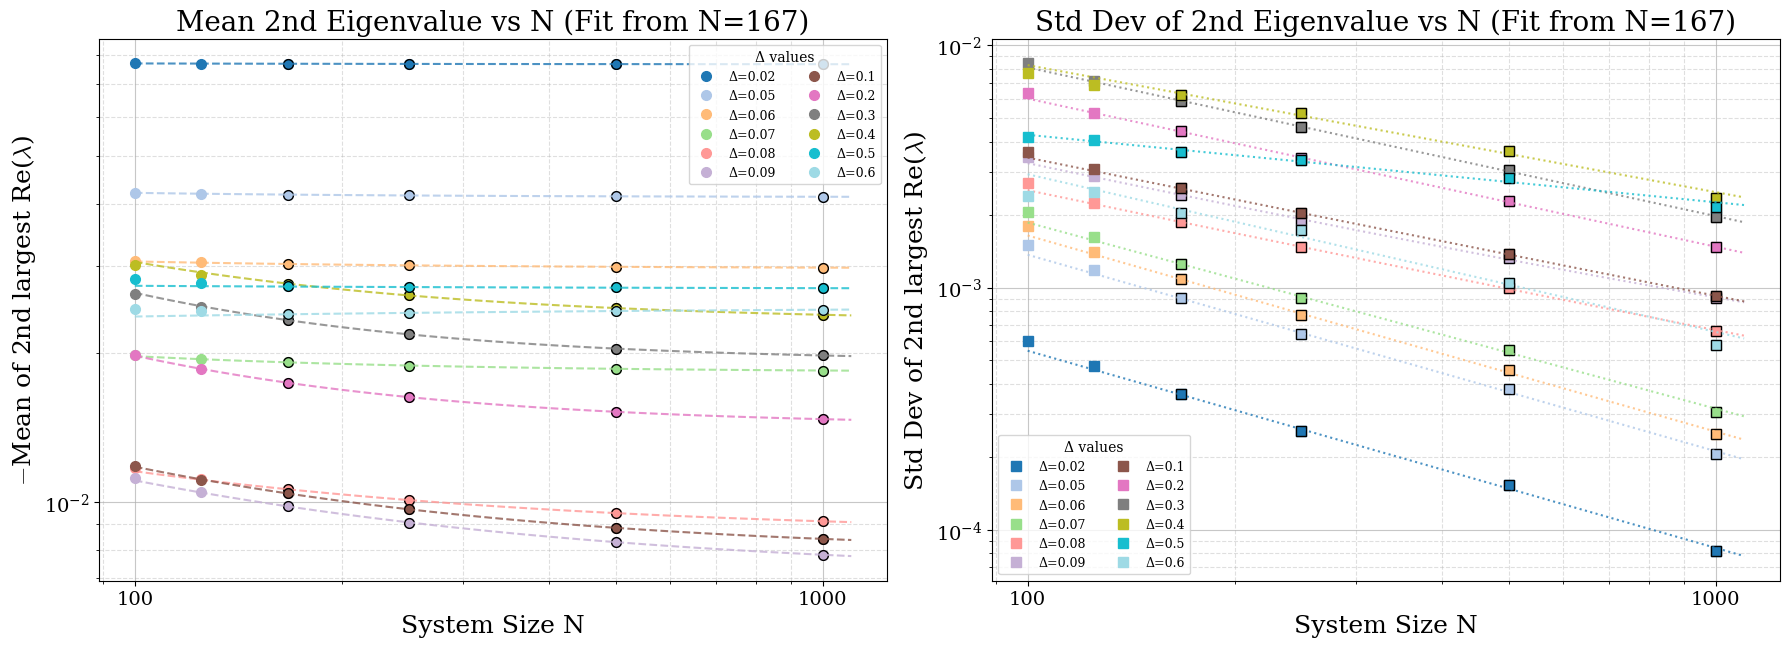

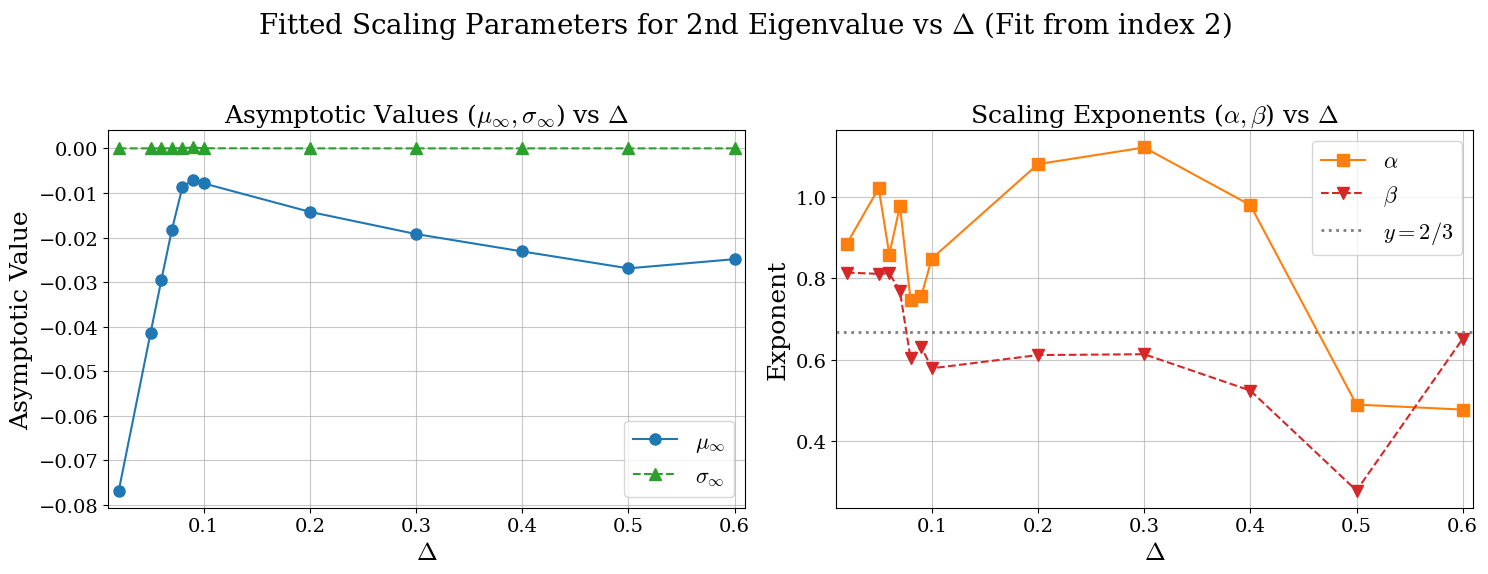

Data vs N plots for rank 2 saved to ../figures/mu_0.0/fig_histogram_z_0.01/rank_2_finite_size_scaling_nonlinear_fit_data_idx2.[png/svg]
Parameter vs Delta plots for rank 2 saved to ../figures/mu_0.0/fig_histogram_z_0.01/rank_2_finite_size_scaling_nonlinear_fit_params_combined_idx2.[png/svg]


In [16]:
# --- Plotting: Data vs N ---
fig_data_fit, (ax_mean, ax_std) = plt.subplots(1, 2, figsize=(18, 7))
colors = plt.get_cmap("tab20", len(delta_vals_to_plot))

for i, delta_val in enumerate(delta_vals_to_plot):
    if delta_val not in results or not results[delta_val]['N']:
        continue

    N_vals_all = np.array(results[delta_val]['N'])
    mean_vals_all = np.array(results[delta_val]['mean'])
    neg_mean_vals_all = -mean_vals_all # Plotting negative mean
    std_vals_all = np.array(results[delta_val]['std'])
    color = colors(i)

    # Plot all available data points
    ax_mean.plot(N_vals_all, neg_mean_vals_all, marker='o', linestyle='None', label=f'Δ={delta_val}', color=color, markersize=7)
    ax_std.plot(N_vals_all, std_vals_all, marker='s', linestyle='None', label=f'Δ={delta_val}', color=color, markersize=7)

    # Highlight points used in fit (using filled markers with black edge)
    if len(N_vals_all) > fit_start_index:
         N_vals_fit_plot = N_vals_all[fit_start_index:]
         neg_mean_vals_fit_plot = neg_mean_vals_all[fit_start_index:]
         std_vals_fit_plot = std_vals_all[fit_start_index:]
         ax_mean.plot(N_vals_fit_plot, neg_mean_vals_fit_plot, marker='o', linestyle='None', color=color, markersize=7, fillstyle='full', markeredgecolor='black', mew=1)
         ax_std.plot(N_vals_fit_plot, std_vals_fit_plot, marker='s', linestyle='None', color=color, markersize=7, fillstyle='full', markeredgecolor='black', mew=1)

    params = fit_parameters_nonlinear.get(delta_val)
    fit_success_mean = params and params['fit_successful_mean']
    fit_success_std = params and params['fit_successful_std']

    # Generate N values for smooth curve plotting
    if len(N_vals_all) > 1:
         N_smooth = np.logspace(np.log10(min(N_vals_all)), np.log10(max(N_vals_all)*1.1), 100) # Extend slightly for visualization
    elif len(N_vals_all) == 1:
         N_smooth = N_vals_all # Just plot the single point if needed
    else:
         continue # Skip if no data points

    # Plot fit lines if successful
    if fit_success_mean:
        mean_fit = model_mean_fit(N_smooth, params['mu_inf'], params['A'], params['alpha'])
        neg_mean_fit = -mean_fit # Plot negative mean fit
        ax_mean.plot(N_smooth, neg_mean_fit, linestyle='--', color=color, alpha=0.8)


    if fit_success_std:
        std_fit = model_std_fit(N_smooth, params['sigma_inf'], params['B'], params['beta'])
        # Add small epsilon to avoid log(0) issues if plotting std on log scale and sigma_inf is 0
        ax_std.plot(N_smooth, std_fit + 1e-18, linestyle=':', color=color, alpha=0.8)

# Formatting Axes for Data vs N plot
for ax in [ax_mean, ax_std]:
    ax.set_xscale('log')
    ax.set_xlabel('System Size N', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}')) # Format x-axis labels as integers
    ax.grid(True, which='major', linestyle='-', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', alpha=0.4)

    # Improve legend handling for clarity
    num_deltas = len(delta_vals_to_plot)
    ncol = 1 if num_deltas <= 10 else 2
    handles, labels = ax.get_legend_handles_labels()
    # Filter out duplicate labels (like from highlighting points)
    by_label = OrderedDict()
    for handle, label in zip(handles, labels):
        if label not in by_label:
            by_label[label] = handle
    ax.legend(by_label.values(), by_label.keys(), fontsize=9, loc='best', ncol=ncol, title="Δ values")

ax_mean.set_yscale('log')
# Use ordinal_rank in the label
ax_mean.set_ylabel(f'$-$Mean of {ordinal_rank} largest Re($\\lambda$)', fontsize=18)
ax_mean.set_title(f'Mean {ordinal_rank} Eigenvalue vs N (Fit from N={N_vals_all[fit_start_index]})', fontsize=20)

ax_std.set_yscale('log')
# Use ordinal_rank in the label
ax_std.set_ylabel(f'Std Dev of {ordinal_rank} largest Re($\\lambda$)', fontsize=18)
ax_std.set_title(f'Std Dev of {ordinal_rank} Eigenvalue vs N (Fit from N={N_vals_all[fit_start_index]})', fontsize=20)

fig_data_fit.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
plt.show()


# --- Plotting: Fitted Parameters vs Delta (Combined) ---
# Create a 1x2 subplot figure
fig_params, axes_params = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
ax_inf = axes_params[0] # Axis for mu_inf and sigma_inf
ax_exp = axes_params[1] # Axis for alpha and beta

# Collect parameters for plotting
deltas_plot = []
mu_infs = []
alphas = []
sigma_infs = []
betas = []

for delta_val in delta_vals_to_plot:
    params = fit_parameters_nonlinear.get(delta_val)
    if params:
        deltas_plot.append(delta_val)
        # Append parameter value if fit was successful, otherwise append NaN
        mu_infs.append(params['mu_inf'] if params['fit_successful_mean'] else np.nan)
        alphas.append(params['alpha'] if params['fit_successful_mean'] else np.nan)
        sigma_infs.append(params['sigma_inf'] if params['fit_successful_std'] else np.nan)
        betas.append(params['beta'] if params['fit_successful_std'] else np.nan)

# Plotting the parameters
if deltas_plot:
    # Plot on ax_inf (mu_inf and sigma_inf)
    # Only plot points where fit was successful (non-NaN)
    ax_inf.plot(deltas_plot, mu_infs, marker='o', linestyle='-', color='C0', label=r'$\mu_{\infty}$', markersize=8)
    ax_inf.plot(deltas_plot, sigma_infs, marker='^', linestyle='--', color='C2', label=r'$\sigma_{\infty}$', markersize=8)
    ax_inf.set_ylabel('Asymptotic Value', fontsize=18)
    ax_inf.legend(fontsize=16)
    ax_inf.set_xlabel(r'$\Delta$', fontsize=18)
    ax_inf.set_title(r'Asymptotic Values ($\mu_{\infty}, \sigma_{\infty}$) vs $\Delta$', fontsize=18)

    # Plot on ax_exp (alpha and beta)
    # Only plot points where fit was successful (non-NaN)
    ax_exp.plot(deltas_plot, alphas, marker='s', linestyle='-', color='C1', label=r'$\alpha$', markersize=8)
    ax_exp.plot(deltas_plot, betas, marker='v', linestyle='--', color='C3', label=r'$\beta$', markersize=8)
    # Plot a horizontal line at y = 2/3 for reference
    ax_exp.axhline(y=2/3, color='gray', linestyle=':', label=r'$y=2/3$', linewidth=2)
    ax_exp.set_ylabel('Exponent', fontsize=18)
    ax_exp.legend(fontsize=16)
    ax_exp.set_xlabel(r'$\Delta$', fontsize=18)
    ax_exp.set_title(r'Scaling Exponents ($\alpha, \beta$) vs $\Delta$', fontsize=18)

else:
    print("No successful fit parameters to plot vs Delta.")


# Common formatting for parameter plots
for ax in axes_params: # Use axes_params directly
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='major', linestyle='-', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', alpha=0.4)
    ax.set_xlim(left=min(deltas_plot)-0.01 if deltas_plot else 0, right=max(deltas_plot)+0.01 if deltas_plot else 1) # Adjust x-limits slightly

# Use ordinal_rank in the super title
fig_params.suptitle(f'Fitted Scaling Parameters for {ordinal_rank} Eigenvalue vs $\Delta$ (Fit from index {fit_start_index})', fontsize=20)
fig_params.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust rect to prevent title overlap
plt.show()


# --- Saving Figures ---
# Ensure mu and input_drive are defined before this block
try:
    # Define base folder using mu and input_drive
    folder_loc = f'../figures/mu_{mu}/fig_histogram_z_{input_drive}/'
    os.makedirs(folder_loc, exist_ok=True) # Create directory if it doesn't exist

    # Update filenames to include the rank
    file_name_data_fit = f'rank_{eigenvalue_rank}_finite_size_scaling_nonlinear_fit_data_idx{fit_start_index}'
    file_save_path_data_fit = os.path.join(folder_loc, file_name_data_fit)

    file_name_params = f'rank_{eigenvalue_rank}_finite_size_scaling_nonlinear_fit_params_combined_idx{fit_start_index}'
    file_save_path_params = os.path.join(folder_loc, file_name_params)

    # Save Data vs N plot
    fig_data_fit.savefig(f'{file_save_path_data_fit}.png', bbox_inches='tight', dpi=300)
    fig_data_fit.savefig(f'{file_save_path_data_fit}.svg', format='svg', bbox_inches='tight')
    print(f"Data vs N plots for rank {eigenvalue_rank} saved to {file_save_path_data_fit}.[png/svg]")

    # Save Parameter vs Delta plot
    fig_params.savefig(f'{file_save_path_params}.png', bbox_inches='tight', dpi=300)
    fig_params.savefig(f'{file_save_path_params}.svg', format='svg', bbox_inches='tight')
    print(f"Parameter vs Delta plots for rank {eigenvalue_rank} saved to {file_save_path_params}.[png/svg]")

except NameError as e:
    # Catch error if mu or input_drive are not defined
    print(f"Warning: Saving failed. Required variable ('mu' or 'input_drive') likely not defined. Error: {e}")
except Exception as e:
    # Catch other potential saving errors
    print(f"An error occurred during figure saving: {e}")

Plotting for delta values: [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


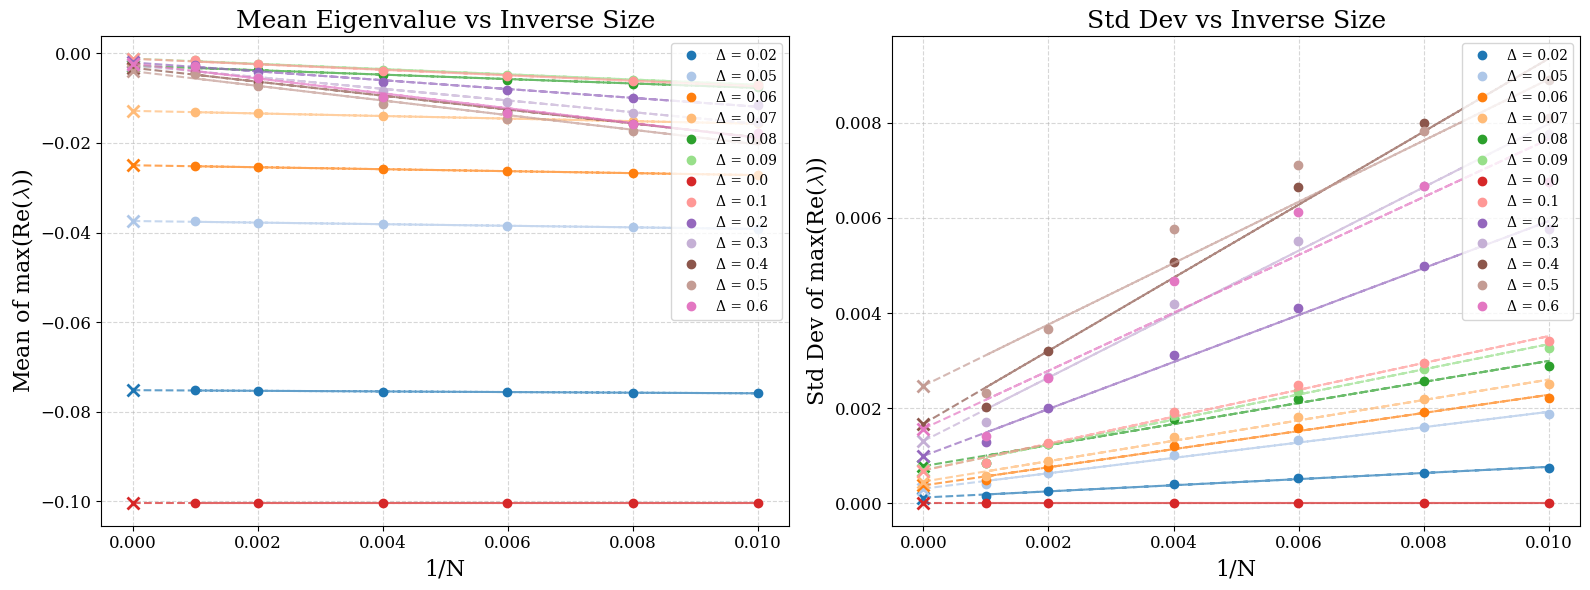

In [28]:
# scaling of eigenvalue with system size (N)
delta_vals_to_plot = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Ensure these delta values exist in the loaded data for all N
available_deltas = set.intersection(*[set(data['eigvals_dict'].keys()) for data in data_by_N.values()])
delta_vals_to_plot = [d for d in delta_vals_to_plot if d in available_deltas]
if not delta_vals_to_plot:
    print("Error: None of the specified delta_vals_to_plot are available for all system sizes.")
else:
    print(f"Plotting for delta values: {delta_vals_to_plot}")

# Prepare data storage
results = {delta: {'1/N': [], 'mean': [], 'std': []} for delta in delta_vals_to_plot}
system_sizes_N = sorted(data_by_N.keys())

# %% Calculate mean and standard deviation for each N and delta
for delta_val in delta_vals_to_plot:
    for N_val in system_sizes_N:
        data = data_by_N[N_val]
        eigvals_dict = data['eigvals_dict']

        if delta_val in eigvals_dict:
            eigvals = eigvals_dict[delta_val]
            # Compute the max real parts scaled by 0.002
            max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002

            # Choose a specific z index (here z_idx = 0)
            z_idx = 0
            max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
            # Keep only non-positive values
            max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
            # Convert tensor to numpy array
            data_arr = max_real_each_trial_input.cpu().numpy()

            if data_arr.size > 0: # Ensure there is data to calculate stats
                 mean_val = np.mean(data_arr)
                 std_val = np.std(data_arr)

                 results[delta_val]['1/N'].append(1.0 / N_val)
                 results[delta_val]['mean'].append(mean_val)
                 results[delta_val]['std'].append(std_val)
            else:
                 print(f"Warning: No non-positive eigenvalues found for N={N_val}, delta={delta_val}. Skipping.")


# %% Perform linear interpolation/extrapolation to 1/N = 0
interpolated_results = {delta: {'mean_inf': None, 'std_inf': None} for delta in delta_vals_to_plot}

for delta_val in delta_vals_to_plot:
    x_data = np.array(results[delta_val]['1/N'])
    y_mean = np.array(results[delta_val]['mean'])
    y_std = np.array(results[delta_val]['std'])

    # Ensure there are enough points for linear regression
    if len(x_data) >= 2:
        # Linear regression for mean
        slope_mean, intercept_mean, _, _, _ = linregress(x_data, y_mean)
        interpolated_results[delta_val]['mean_inf'] = intercept_mean
        results[delta_val]['mean_fit_slope'] = slope_mean # Store slope for plotting line

        # Linear regression for standard deviation
        slope_std, intercept_std, _, _, _ = linregress(x_data, y_std)
        interpolated_results[delta_val]['std_inf'] = intercept_std
        results[delta_val]['std_fit_slope'] = slope_std # Store slope for plotting line
    else:
         print(f"Warning: Not enough data points (<2) for delta={delta_val} to perform linear extrapolation.")


# %% Plotting
fig, (ax_mean, ax_std) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

colors = plt.get_cmap("tab20")

for i, delta_val in enumerate(delta_vals_to_plot):
    # common x
    x = np.array(results[delta_val]['1/N'])
    color = colors(i)

    # --- Left: Mean plot ---
    y = np.array(results[delta_val]['mean'])
    ax_mean.plot(x, y,
                 marker='o', linestyle='None',
                 label=f'Δ = {delta_val}',
                 color=color, markersize=6)
    # fit & extrapolate
    if interpolated_results[delta_val]['mean_inf'] is not None:
        intercept = interpolated_results[delta_val]['mean_inf']
        slope     = results[delta_val]['mean_fit_slope']
        x_fit = np.concatenate([[0], x])
        y_fit = slope * x_fit + intercept
        ax_mean.plot(x_fit, y_fit,
                     linestyle='--', alpha=0.7,
                     color=color)
        ax_mean.plot(0, intercept,
                     marker='x', markersize=8,
                     markeredgewidth=2, color=color)

    # --- Right: Std plot ---
    y2 = np.array(results[delta_val]['std'])
    ax_std.plot(x, y2,
                marker='o', linestyle='None',
                label=f'Δ = {delta_val}',
                color=color, markersize=6)
    if interpolated_results[delta_val]['std_inf'] is not None:
        intercept2 = interpolated_results[delta_val]['std_inf']
        slope2     = results[delta_val]['std_fit_slope']
        x_fit2 = np.concatenate([[0], x])
        y_fit2 = slope2 * x_fit2 + intercept2
        ax_std.plot(x_fit2, y_fit2,
                    linestyle='--', alpha=0.7,
                    color=color)
        ax_std.plot(0, intercept2,
                    marker='x', markersize=8,
                    markeredgewidth=2, color=color)

# format the mean subplot
ax_mean.set_xlabel('1/N', fontsize=16)
ax_mean.set_ylabel(r'Mean of max(Re($\lambda$))', fontsize=16)
ax_mean.set_title('Mean Eigenvalue vs Inverse Size', fontsize=18)
ax_mean.tick_params(axis='both', labelsize=12)
ax_mean.grid(True, linestyle='--', alpha=0.5)
ax_mean.legend(fontsize=10, loc='upper right')

# format the std subplot
ax_std.set_xlabel('1/N', fontsize=16)
ax_std.set_ylabel(r'Std Dev of max(Re($\lambda$))', fontsize=16)
ax_std.set_title('Std Dev vs Inverse Size', fontsize=18)
ax_std.tick_params(axis='both', labelsize=12)
ax_std.grid(True, linestyle='--', alpha=0.5)
ax_std.legend(fontsize=10, loc='upper right')
# ax_std.set_ylim(bottom=0)

fig.tight_layout()

# save the figure
folder_loc = f'../figures/mu_{mu}/fig_histogram_z_{input_drive}/'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'finite_size_scaling'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

Plotting for delta values: [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


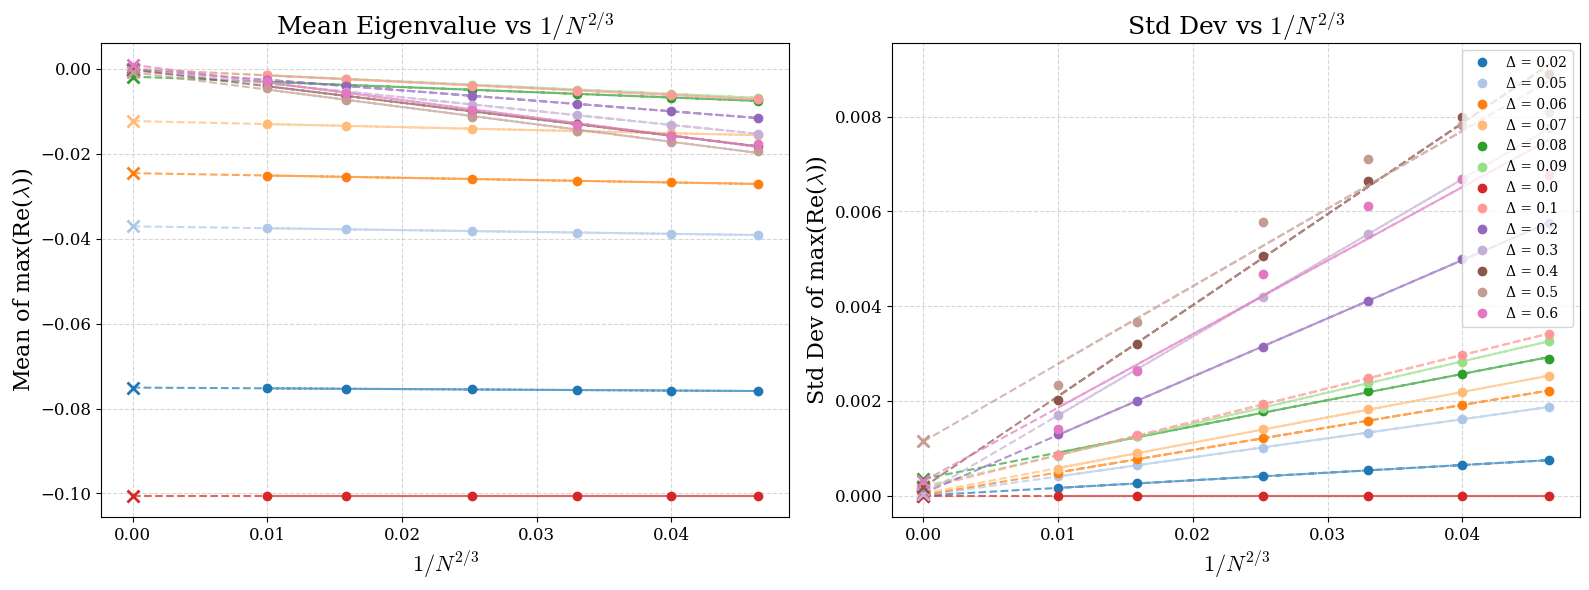

In [9]:
# scaling of eigenvalue with system size (N)
delta_vals_to_plot = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Ensure these delta values exist in the loaded data for all N
available_deltas = set.intersection(*[set(data['eigvals_dict'].keys()) for data in data_by_N.values()])
delta_vals_to_plot = [d for d in delta_vals_to_plot if d in available_deltas]
if not delta_vals_to_plot:
    print("Error: None of the specified delta_vals_to_plot are available for all system sizes.")
else:
    print(f"Plotting for delta values: {delta_vals_to_plot}")

# Prepare data storage
results = {delta: {'1/N_pow_2_3': [], 'mean': [], 'std': []} for delta in delta_vals_to_plot} # Changed key name
system_sizes_N = sorted(data_by_N.keys())

# %% Calculate mean and standard deviation for each N and delta
for delta_val in delta_vals_to_plot:
    for N_val in system_sizes_N:
        data = data_by_N[N_val]
        eigvals_dict = data['eigvals_dict']

        if delta_val in eigvals_dict:
            eigvals = eigvals_dict[delta_val]
            # Compute the max real parts scaled by 0.002
            max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002

            # Choose a specific z index (here z_idx = 0)
            z_idx = 0
            max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
            # Keep only non-positive values
            max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
            # Convert tensor to numpy array
            data_arr = max_real_each_trial_input.cpu().numpy()

            if data_arr.size > 0: # Ensure there is data to calculate stats
                 mean_val = np.mean(data_arr)
                 std_val = np.std(data_arr)

                 # Calculate 1/N^(2/3)
                 x_val = 1.0 / (N_val**(2/3)) # Changed calculation
                 results[delta_val]['1/N_pow_2_3'].append(x_val) # Use new key and value
                 results[delta_val]['mean'].append(mean_val)
                 results[delta_val]['std'].append(std_val)
            else:
                 print(f"Warning: No non-positive eigenvalues found for N={N_val}, delta={delta_val}. Skipping.")


# %% Perform linear interpolation/extrapolation to 1/N^(2/3) = 0
interpolated_results = {delta: {'mean_inf': None, 'std_inf': None} for delta in delta_vals_to_plot}

for delta_val in delta_vals_to_plot:
    x_data = np.array(results[delta_val]['1/N_pow_2_3']) # Use new key for x-data
    y_mean = np.array(results[delta_val]['mean'])
    y_std = np.array(results[delta_val]['std'])

    # Ensure there are enough points for linear regression
    if len(x_data) >= 2:
        # Linear regression for mean
        slope_mean, intercept_mean, _, _, _ = linregress(x_data, y_mean)
        interpolated_results[delta_val]['mean_inf'] = intercept_mean
        results[delta_val]['mean_fit_slope'] = slope_mean # Store slope for plotting line

        # Linear regression for standard deviation
        slope_std, intercept_std, _, _, _ = linregress(x_data, y_std)
        interpolated_results[delta_val]['std_inf'] = intercept_std
        results[delta_val]['std_fit_slope'] = slope_std # Store slope for plotting line
    else:
         print(f"Warning: Not enough data points (<2) for delta={delta_val} to perform linear extrapolation.")


# %% Plotting
fig, (ax_mean, ax_std) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

colors = plt.get_cmap("tab20")

for i, delta_val in enumerate(delta_vals_to_plot):
    # common x, now 1/N^(2/3)
    x = np.array(results[delta_val]['1/N_pow_2_3']) # Use new key for plotting x-data
    color = colors(i)

    # --- Left: Mean plot ---
    y = np.array(results[delta_val]['mean'])
    ax_mean.plot(x, y,
                 marker='o', linestyle='None',
                 label=f'Δ = {delta_val}',
                 color=color, markersize=6)
    # fit & extrapolate
    if interpolated_results[delta_val]['mean_inf'] is not None:
        intercept = interpolated_results[delta_val]['mean_inf']
        slope     = results[delta_val]['mean_fit_slope']
        x_fit = np.concatenate([[0], x]) # x=0 corresponds to N -> infinity
        y_fit = slope * x_fit + intercept
        ax_mean.plot(x_fit, y_fit,
                     linestyle='--', alpha=0.7,
                     color=color)
        ax_mean.plot(0, intercept,
                     marker='x', markersize=8,
                     markeredgewidth=2, color=color)

    # --- Right: Std plot ---
    y2 = np.array(results[delta_val]['std'])
    ax_std.plot(x, y2,
                marker='o', linestyle='None',
                label=f'Δ = {delta_val}',
                color=color, markersize=6)
    if interpolated_results[delta_val]['std_inf'] is not None:
        intercept2 = interpolated_results[delta_val]['std_inf']
        slope2     = results[delta_val]['std_fit_slope']
        x_fit2 = np.concatenate([[0], x]) # x=0 corresponds to N -> infinity
        y_fit2 = slope2 * x_fit2 + intercept2
        ax_std.plot(x_fit2, y_fit2,
                    linestyle='--', alpha=0.7,
                    color=color)
        ax_std.plot(0, intercept2,
                    marker='x', markersize=8,
                    markeredgewidth=2, color=color)

# format the mean subplot
ax_mean.set_xlabel('$1/N^{2/3}$', fontsize=16) # Changed x-axis label
ax_mean.set_ylabel(r'Mean of max(Re($\lambda$))', fontsize=16)
ax_mean.set_title('Mean Eigenvalue vs $1/N^{2/3}$', fontsize=18) # Changed title
ax_mean.tick_params(axis='both', labelsize=12)
ax_mean.grid(True, linestyle='--', alpha=0.5)
# ax_mean.legend(fontsize=10, loc='upper right')

# format the std subplot
ax_std.set_xlabel('$1/N^{2/3}$', fontsize=16) # Changed x-axis label
ax_std.set_ylabel(r'Std Dev of max(Re($\lambda$))', fontsize=16)
ax_std.set_title('Std Dev vs $1/N^{2/3}$', fontsize=18) # Changed title
ax_std.tick_params(axis='both', labelsize=12)
ax_std.grid(True, linestyle='--', alpha=0.5)
ax_std.legend(fontsize=10, loc='upper right')
# ax_std.set_ylim(bottom=0)

fig.tight_layout()

# save the figure
folder_loc = f'../figures/mu_{mu}/fig_histogram_z_{input_drive}/'
os.makedirs(folder_loc, exist_ok=True)
# Modify filename if desired to reflect the new scaling
file_name = f'finite_size_scaling_N_pow_2_3' # Optional: change file name
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()